# **Assignment Roadmap**

This assignment asks you to build a complete Brain-Computer Interface (BCI) pipeline. Your goal is to take raw, noisy electrical brain signals and turn them into a clear Yes/No decision: Is this the character the user wants?

**Theres not much theory to learn other than implementation, you have to learn this by doing**

## AI Usage Policy for This Assignment

You're welcome to use AI for this assignment. Given the complexity of EEG signal processing and machine learning,
We don't expect you to know every implementation detail from scratch and neither does any recuiter or any professor.


Use AI to:

    Debug errors and troubleshoot issues

    Understand concepts and explore different approaches

What matters:

    You understand your code and can explain how it works

    You learn from the process, not just copy-paste

### **1: Cleaning the Signal (Preprocessing)**

The Goal: Raw EEG data is full of "garbage" frequencies like muscle movement and electrical hum. You need to filter the data to keep only the brain waves relevant to the P300 response (typically 0.1Hz – 20Hz).

You have already done this in the previous assignment but this one is a more standard procedure.

Common Pitfalls:

    Filter Lag: Standard filters can delay the signal, meaning the brain response looks like it happened later than it actually did. To prevent this, use zero-phase filtering (e.g., scipy.signal.filtfilt) instead of standard filtering (lfilter).

    Aliasing: You are asked to downsample the data from 240Hz to 60Hz to make it faster to process. Do not simply slice the array (e.g., data[::4]) without filtering first. If you do, high-frequency noise will "fold over" into your low frequencies and corrupt the data. Always filter before downsampling.

### **2: Epoch Extraction**

The Goal: You need to convert the continuous stream of data into specific "events" or "epochs."

The Concept: A P300 response happens roughly 300ms after a flash. Your code needs to identify every moment a flash occurs (stimulus_onset), look forward in time (e.g., 800ms), and "snip" that window of data out.

Visualizing the Data Structure:

    Input: A continuous 2D matrix (Total_Time_Points, 64_Channels)

    Output: A 3D block of events (Number_of_Flashes, Time_Points_Per_Window, 64_Channels)

Common Pitfall:

    Indexing Errors: This dataset may originate from MATLAB (which uses 1-based indexing), while Python uses 0-based indexing. If your index calculation is off by even one sample, your window will shift, and the machine learning model will be training on random noise rather than the brain response. Double-check your start and end indices.

### **3: Making Data "Model-Ready" (Feature Engineering)**

The Goal: Standard Machine Learning models (like SVM or LDA) cannot understand 3D arrays. They generally require a 2D matrix (like an Excel sheet). The Task:

    Time Domain: You will need to "flatten" the epochs. If an epoch is 60 time points × 64 channels, it becomes a single flat row of 3,840 numbers.

    PCA/CSP: These are compression techniques. The goal is to reduce those 3,840 numbers down to perhaps 20 numbers that capture the most important information.

Common Pitfall:

    Data Leakage: When using PCA or CSP, you must be careful not to "cheat." You should .fit() your reducer only on the training data, and then .transform() the test data. If you fit on the combined dataset, your model "sees" the test answers ahead of time, leading to artificially high scores that won't work in the real world.

### **4: Classification**

The Goal: Feed your features into the ML models (LDA, SVM, etc.) provided in the skeleton code to classify "Target" vs. "Non-Target" flashes.

Common Pitfall:

    Class Imbalance: In a P300 speller, the letter the user wants (Target) only flashes 1 out of 6 times. The other 5 flashes are Non-Targets.

        If your model decides to simply guess "Non-Target" every single time, it will still achieve ~83% accuracy. This is a useless model.

        Do not rely solely on Accuracy. Check the F1-Score or the Confusion Matrix. A good model must be able to correctly identify the rare Target events, not just the frequent Non-Targets.

In [1]:
# The assignment is structured in a way that its modular so thats its easier to debug whats wrong
!pip install mne
from mne.decoding import CSP
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import butter, filtfilt, iirnotch,find_peaks,resample
from scipy.linalg import eigh
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix)

import pickle
import json
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
################################################################################
# SECTION 1: DATA LOADING AND BASIC SETUP
################################################################################

# Character matrix (6x6) for P300 speller
CHAR_MATRIX = np.array([
    ['A', 'B', 'C', 'D', 'E', 'F'],
    ['G', 'H', 'I', 'J', 'K', 'L'],
    ['M', 'N', 'O', 'P', 'Q', 'R'],
    ['S', 'T', 'U', 'V', 'W', 'X'],
    ['Y', 'Z', '1', '2', '3', '4'],
    ['5', '6', '7', '8', '9', '_']
])

def load_data(file_path):
  mat_data=sio.loadmat(file_path)
  return mat_data





    # Training data has labels, test data doesn't


def get_char_from_codes(row_code, col_code):
    """Convert row/column stimulus codes to character"""



In [3]:
################################################################################
# SECTION 2: EEG SIGNAL ACQUISITION & PREPROCESSING
################################################################################
#extracting and reshaping eeg signal
def extract_signal(mat_data):
 signal=mat_data['Signal']
 x,y,z=signal.shape
 signal= np.transpose(signal, axes=(0, 2, 1))
 signal= signal.reshape(z, x*y)
 signal=signal*1e-6 #conerting to microvolts
 return signal
def bandpass_filter(signal, lowcut=0.1, highcut=20, fs=240, order=5):
    nyq = 0.5 * fs #half sampling rate
    low = lowcut / nyq #normalizing cutoff to nyq
    high = highcut / nyq #normalizing cutoff to nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal, axis=-1)


    """
    Apply band-pass filter to remove low-frequency drift and high-frequency noise
    Typical P300 band: 0.1-20 Hz
    """


def notch_filter(signal, freq=50, fs=240, Q=30):
  b, a = iirnotch(freq / (fs / 2), Q)
  for ch in range(signal.shape[0]):
    signal[ch] = filtfilt(b, a, signal[ch])
    """
    Remove powerline interference (50/60 Hz)
    """


def baseline_correction(epoch, baseline_samples=50):
    """
    Apply baseline correction by subtracting pre-stimulus baseline mean.
    Subtracts the mean of the first `baseline_samples` from each time point across channels.
    """
    if baseline_samples >= epoch.shape[0]:
        raise ValueError("baseline_samples must be less than epoch length")

    baseline_mean = np.mean(epoch[:baseline_samples, :], axis=0)  # Mean per channel or you can understand as per epoch
    corrected_epoch = epoch - baseline_mean
    return corrected_epoch


def downsample_signal(signal, original_fs=240, target_fs=60):
  #lesser data improves computational efficiency
  num_samples = int(len(signal) * target_fs / original_fs)
  signal = resample(signal, num_samples)




def artifact_rejection(signal, threshold=100):
  abs_signal = np.abs(signal)
  mask = abs_signal < threshold
  return np.where(mask, signal, np.nan)




def preprocess_pipeline(data, apply_bandpass=True, apply_notch=True,
                       apply_downsample=True, fs=240):
  data=bandpass_filter(data, lowcut=0.1, highcut=20, fs=240, order=5)
  notch_filter(data, freq=50, fs=240, Q=30)
  downsample_signal(data, original_fs=240, target_fs=60)
  return data

  """
    Complete preprocessing pipeline:
    1. Bandpass filtering (0.1-20 Hz)
    2. Notch filtering (50 Hz)
    3. Downsampling (240->60 Hz)
    """

def extract_epochs(data, epoch_length_ms=800, fs=60):
    """
    Extract epochs around stimulus onset
    - Event tagging: Use flashing signal to detect stimulus onset
    - Stimulus alignment: Extract fixed-length windows after each flash
    - Epoch extraction: Collect all stimulus-locked epochs

    Returns: Dictionary with epochs, labels, codes, character indices
    """
    epoch_samples = int((epoch_length_ms / 1000) * fs)

    signal = data['Signal']
    flashing = data['Flashing']
    stimulus_code = data['StimulusCode']
    stimulus_type = data.get('StimulusType')#returns none if key StimulusType is not present

    epochs_list = []
    labels_list = []
    codes_list = []
    char_idx_list = []

    n_chars = signal.shape[0]

    for char_idx in range(n_chars):
        char_signal = signal[char_idx]
        char_flashing = flashing[char_idx]
        char_code = stimulus_code[char_idx]
        char_type = stimulus_type[char_idx] if stimulus_type is not None else None

        # Find stimulus onsets (flashing goes from 0 to 1)
        flash_onsets = np.where(np.diff(char_flashing) == 1)[0] + 1

        for onset in flash_onsets:
            if onset + epoch_samples <= len(char_signal):
                epoch = char_signal[onset:onset + epoch_samples, :]

                # Apply baseline correction
                epoch = baseline_correction(epoch, baseline_samples=10)

                code = char_code[onset]
                label = char_type[onset] if char_type is not None else -1

                epochs_list.append(epoch)
                labels_list.append(label)
                codes_list.append(code)
                char_idx_list.append(char_idx)

    epochs = np.array(epochs_list) #epochs has shape (n_epochs,n_samples, n_channels);n_epochs is the total number of stimulus onsets and epoch_samples is time points per epoch
    labels = np.array(labels_list)
    codes = np.array(codes_list)
    char_indices = np.array(char_idx_list)
    return {'epochs':epochs,'labels':labels,'codes':codes,'char_indices':char_indices}

def plot_erp_responses(epoch_data, channel_idx=31, fs=60):
 time = np.arange(epoch_data.shape[1]) / fs * 1000  # Time in ms
 p300_start = int(250 * fs / 1000)  #multiplying by fs/1000 gives the index;in this it is the 15th sample
 p300_end = int(500 * fs / 1000)
 data = epoch_data[:,p300_start:p300_end, channel_idx].mean(axis=0)
 peaks, _ = find_peaks(data, height=0)
 p300_peak_idx = peaks[np.argmax(data[peaks])]  # Highest peak index
 p300_amplitude = data[p300_peak_idx] - 0
 p300_latency_ms = time[p300_start + p300_peak_idx]# timestamp where peak oocurs
 plt.figure(figsize=(10, 5))

 plt.plot(time[p300_start:p300_end], data)
 plt.axvspan(250, 500, alpha=0.2, color='yellow', label='P300 window') #adds a yellow semi transparent shaded region(rectangle)
 if not np.isnan(p300_amplitude):
    plt.plot([p300_latency_ms], [p300_amplitude], 'ro', markersize=10, label='P300 peak') #highlights the peak in red colour
 plt.axhline(0, color='k', linestyle='--', alpha=0.5) #adds a baseline for reference
 plt.xlabel('Time (ms)'); plt.ylabel('Voltage (µV)'); plt.title('ERP at Cz'); plt.legend()
 plt.show()
"""
    Visualize ERP responses and confirm P300 peaks around 300ms
    Channel 31 = Cz (central midline electrode, best for P300)
    """
    # Plot averages with standard error




    # Mark P300 peak region




    # Calculate P300 amplitude difference




'\n    Visualize ERP responses and confirm P300 peaks around 300ms\n    Channel 31 = Cz (central midline electrode, best for P300)\n    '

In [4]:
#################################################################################
# SECTION 3: FEATURE ENGINEERING & BASELINE CLASSIFIERS
################################################################################

def extract_time_domain_features(epochs):
    n_epochs = epochs.shape[0]
    features = epochs.reshape(n_epochs, -1)
    return features
    """Extract time-domain features: simply flatten the epochs
    Shape: (n_epochs, n_samples * n_channels)
    """

def extract_pca_features(train_epochs, n_components=20):
  #flattening sicne pca requires 2D input:(n_epochs,n_samples*n_channels=n_features)
  epochs_transformed=np.transpose(train_epochs,axes=(1,0,2))
  x,y,z= epochs_transformed.shape
  epochs_transformed=epochs_transformed.reshape(y,x*z)
  scaler=StandardScaler() #transforms features so they all have a mean = 0 and standard deviation = 1 which helps PCA to treat all features equally.
  epochs_transformed=scaler.fit_transform(epochs_transformed)
  pca=PCA(n_components=n_components,random_state=42)
  epochs_transformed=pca.fit_transform(epochs_transformed)
  return epochs_transformed,pca
  """
  Extract PCA features for dimensionality reduction
  Reduces (n_samples * n_channels) to n_components
  https://www.geeksforgeeks.org/machine-learning/implementing-pca-in-python-with-scikit-learn/
  """
def extract_csp_features(epochs, labels, n_components=6):
    """
    Common Spatial Patterns (CSP) for discriminative spatial filters
    Finds spatial filters that maximize variance ratio between classes
    """
    target_epochs = epochs[labels == 1]
    non_target_epochs = epochs[labels == 0]


    # Compute covariance matrices
    def compute_cov(epochs):
      epochs = epochs - np.mean(epochs, axis=(0, 1), keepdims=True)
      n_trials, n_times, n_channels = epochs.shape
      covs = []
      for trial in epochs:
        # Covariance per trial: (channels, channels)
        cov = np.cov(trial)
        covs.append(cov)
      cov=np.mean(covs, axis=0)  # Average across trials
      """What happens here:
         Trial 1: [ch1(t1),ch1(t2),...,ch1(t250)]  →  np.cov(trial) → Cov1 (22×22)
         [ch2(t1),ch2(t2),...,ch2(t250)]  ↑
         [ch22(t1),ch22(t2),...,ch22(t250)]

         Trial 2: Same → Cov2 (22×22)
         ...
         Trial 50: Same → Cov50 (22×22)

         Result: covs = [Cov1, Cov2, ..., Cov50]  # List of 50 matrices"""
      return cov
    cov_target=compute_cov(target_epochs)
    cov_non_target=compute_cov(non_target_epochs)
    cov_total=cov_target+cov_non_target

    # Solve generalized eigenvalue problem
    evals, evecs = eigh(cov_target, cov_total)
    # Select most discriminative components (extreme eigenvalues)
    filters = evecs[:, -n_components//2:].real  # Last n/2 for non-target maximizing; .real is necessary since eigh uses complex mathematical funcs and might generate small garbage imaginary numbers.
    filters = np.hstack([evecs[:, :n_components//2].real, filters])  # First n/2 + last n/2

    # Extract CSP features (log variance)
    def get_features(epochs, filters):
          projected = np.array([np.dot(epoch, filters) for epoch in epochs])  # Apply filters
          variances = (projected ** 2).mean(-1)  # Power (squared) averaged over time
          return np.log(variances)  # log of the variances are fetaures;taking logs provides better stability for ML models

    target_features = get_features(target_epochs, filters)
    non_target_features = get_features(non_target_epochs, filters)
    features = np.vstack([non_target_features, target_features])
    return features,filters


def extract_features(epoch_data, method='pca', n_components=20,labels=None):
  if method == 'time_domain':
       extract_time_domain_features(epoch_data)
       return epoch_data
  elif method=='pca':
    return extract_pca_features(epoch_data,n_components=20)
  elif method=='csp':
   # Handle CSP label issues
   if method == 'csp':
        unique_labels = np.unique(labels)
        if len(unique_labels) < 2:
            print("❌ ERROR: Need at least 2 classes for CSP")
            return None, None
        label_map = {unique_labels[0]: 0, unique_labels[1]: 1}
        binary_labels = np.array([label_map[label] for label in labels])
        if np.sum(binary_labels == 1) == 0 or np.sum(binary_labels == 0) == 0:
            print("❌ ERROR: No samples in one class")
            return None, None
        csp = CSP(n_components=min(n_components, epoch_data.shape[1]), reg=None, log=True, norm_trace=False)#reg=None means no regularization applied.



        X_csp = csp.fit_transform(epoch_data, binary_labels)
        return X_csp, csp



  """
  Feature extraction wrapper supporting multiple methods:
  - time_domain: Raw time-domain samples (flattened)
  - pca: Principal Component Analysis
  - csp: Common Spatial Patterns
  """


def train_lda_classifier(X_train, y_train):
    """
    Linear Discriminant Analysis with balanced priors
    https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
    """
    lda = LDA(priors=None, solver='svd')
    lda.fit(X_train, y_train)

    return lda

def train_logistic_regression(X_train, y_train):
    """
    Logistic Regression - baseline classifier
    https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    """
    model = LogisticRegression()  # Creates the model object
    model.fit(X_train, y_train)   # Trains it on data
    return model

def evaluate_classifier(model, X_test, y_test, model_name="Model"):
    """
    Comprehensive classifier evaluation
    """
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')  # 'weighted' for multi-class
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    results=pd.DataFrame([['accuracy',accuracy],['precision ',precision],['recall',recall],['f1',f1]],columns=['Metric',['Value']])
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix for {model_name}:")
    print(cm)
    # Optional: Visualize it
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    results.loc[len(results)] = ['ROC AUC', roc_auc]  # Append to DataFrame
    results.loc[len(results)] = ['accuracy', accuracy]  # Append to DataFrame
    print(results.round(4))
    return results

class CSPTransformer:
    """
    Wrapper for CSP filters to enable transform() method
    """
    def __init__(self, filters=None):
     self.filters=filters
    def transform(self, X):
     if self.filters is None:
            raise ValueError("Fit filters first!")
     return np.dot(X, self.filters.T)


In [5]:
################################################################################
# SECTION 4: CLASSICAL MACHINE LEARNING MODELS
################################################################################

def train_svm_classifier(X_train, y_train, kernel='rbf', C=1.0):
    """
    Support Vector Machine with RBF kernel
    Good for non-linear decision boundaries
    https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    """
    model = Pipeline([("scaler", StandardScaler()), ("svc", SVC(kernel=kernel, C=C, probability=True))])
    #Pipeline is a trained model that first scales the data, then applies SVM.(Scaling is necessary for SVM)

    model.fit(X_train, y_train)
    # Fit (train) the model on the training data
    svm_A = model.named_steps['svc']      # Fitted SVM
    scaler_A = model.named_steps['scaler'] # Fitted scaler
    return svm_A,scaler_A

def train_random_forest(X_train, y_train, n_estimators=100):
    """
    Random Forest Classifier
    Ensemble method, robust to overfitting
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    """
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    return model

def train_gradient_boosting(X_train, y_train, n_estimators=100):
    """
    Gradient Boosting Classifier with manual sample weighting
    (GradientBoosting doesn't support class_weight parameter)
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
    """
    print(f"\n  Training Gradient Boosting (n_estimators={n_estimators})...")

    # Calculate sample weights manually

    classes, counts = np.unique(y_train, return_counts=True)
    total_samples = len(y_train)
    n_classes = len(classes)
    class_weights = total_samples / (n_classes * counts)
    model = GradientBoostingClassifier(n_estimators=n_estimators,  random_state=42,subsample=1.0)#subsample=1 means use full dataset
    sample_weights=np.zeros_like(y_train)
    for i,cls in enumerate(classes):
      sample_weights[y_train==cls]=class_weights[i]
    model.fit(X_train, y_train, sample_weight=sample_weights)#sample_weight parameter tells each tree: "When calculating split quality (e.g., Gini impurity), multiply errors by these weights."
    return model
def compare_all_classical_models(X_train, y_train, X_test, y_test):
    """
    Train and compare all classical ML models
    Returns performance comparison
    """


    # Calculate sample weights once for methods that need it.This prevents majority class bias.
    sample_weights = None  # Default if no imbalance
    if len(set(y_train)) > 1:
     sample_weights = compute_sample_weight('balanced', y_train)

    # Define models to train
    models = {'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
   'SVM': SVC(random_state=42, probability=True),
   'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
   'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100)}

        # Training
    trained_models = {}
    for name, model in models.items():
     model.fit(X_train, y_train, sample_weight=sample_weights)
     trained_models[name] = model

        # Inference


        # Metrics
    results = {}
    for name, model in trained_models.items():
     y_pred = model.predict(X_test)
     results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred, average='weighted'),
        'Classification Report': classification_report(y_test, y_pred)
     }
    # Summary table
    summary_data = [{'Model': name, **metrics} for name, metrics in results.items()]#creating list of dictionaries,one corresponding to each model,from nested disctionaries. This makes data ready for pandas dataframe.
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('F1-Score', ascending=False).round(4).reset_index(drop=True)

    return {'trained_models': trained_models,'results': results,'summary_table': summary_df}
def save_model(model, filepath):
    """Save model to pickle file"""
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"\n  Model saved to: {filepath}")

def load_model(filepath):
    """Load model from pickle file"""
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    print(f"\n  Model loaded from: {filepath}")
    return model

In [6]:
    # ========================================================================
    # STEP 1: LOAD DATA
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 1: LOADING DATA")
    print("="*70)


    from google.colab import drive
    drive.mount('/content/drive')
    train_data_A = load_data('/content/drive/MyDrive/Subject_A_Train.mat')
    test_data_A = load_data('/content/drive/MyDrive/Subject_A_Test.mat')
    train_data_B = load_data('/content/drive/MyDrive/Subject_B_Train.mat')
    test_data_B = load_data('/content/drive/MyDrive/Subject_B_Test.mat')



STEP 1: LOADING DATA
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
    # ========================================================================
    # STEP 2: PREPROCESSING
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 2: PREPROCESSING")
    print("="*70)

    print("\n--- Subject A ---")
    train_signal_A=extract_signal(train_data_A)
    test_signal_A=extract_signal(test_data_A)
    train_proc_A = preprocess_pipeline(train_signal_A)
    test_proc_A = preprocess_pipeline(test_signal_A)

    print("\n--- Subject B ---")
    train_signal_B=extract_signal(train_data_B)
    test_signal_B=extract_signal(test_data_B)
    train_proc_B = preprocess_pipeline(train_signal_B)
    test_proc_B = preprocess_pipeline(test_signal_B)



STEP 2: PREPROCESSING

--- Subject A ---

--- Subject B ---


In [8]:
    # ========================================================================
    # STEP 3: EPOCH EXTRACTION
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 3: EPOCH EXTRACTION")
    print("="*70)

    print("\n--- Subject A ---")
    train_epochs_A = extract_epochs(train_data_A, epoch_length_ms=800, fs=60)
    test_epochs_A = extract_epochs(test_data_A, epoch_length_ms=800, fs=60)

    print("\n--- Subject B ---")
    train_epochs_B = extract_epochs(train_data_B, epoch_length_ms=800, fs=60)
    test_epochs_B = extract_epochs(test_data_B, epoch_length_ms=800, fs=60)


STEP 3: EPOCH EXTRACTION

--- Subject A ---

--- Subject B ---



STEP 4: VISUALIZING ERP RESPONSES

--- Subject A ---


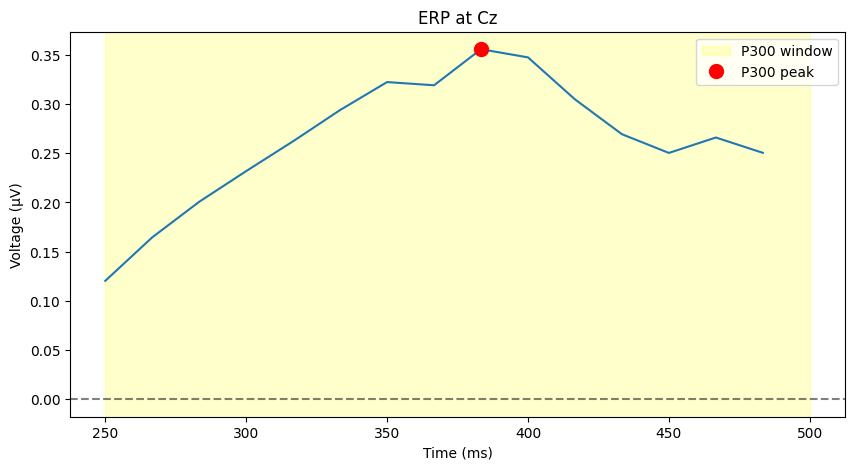

In [9]:
    # ========================================================================
    # STEP 4: VISUALIZE ERP
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 4: VISUALIZING ERP RESPONSES")
    print("="*70)

    print("\n--- Subject A ---")
    plot_erp_responses(train_epochs_A.get('epochs'), channel_idx=31)

In [10]:
    # ========================================================================
    # STEP 5: FEATURE EXTRACTION
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 5: FEATURE EXTRACTION")
    print("="*70)

    # ========================================================================
    # Subject A: Compare PCA vs CSP vs Time-Domain
    # ========================================================================
    print("\n--- Subject A: Feature Comparison ---")

    # Try PCA (20 components)
    X_train_pca20, pca20_A = extract_features(train_epochs_A.get('epochs'), method='pca', n_components=20)
    X_test_pca20 = pca20_A.transform(test_epochs_A['epochs'].reshape(test_epochs_A['epochs'].shape[0], -1))#reshaping from (n_epochs,n_samples,n_channels) to (n_epochs,n_samples*n_channels) since pca requires 2D input

    # Try PCA (50 components)
    X_train_pca50, pca50_A = extract_features(train_epochs_A.get('epochs'), method='pca', n_components=50)
    X_test_pca50 = pca50_A.transform(test_epochs_A['epochs'].reshape(test_epochs_A['epochs'].shape[0], -1))

    # Try CSP
    X_train_csp, csp_A = extract_features(train_epochs_A.get('epochs'), 'csp',6,train_epochs_A.get('labels'))
    X_test_csp = csp_A.transform(test_epochs_A.get('epochs'))
    # Try Raw Time-Domain Features
    X_train_time=extract_time_domain_features(train_epochs_A.get('epochs'))
    X_test_time=extract_time_domain_features(test_epochs_A.get('epochs'))



    # Quick comparison with BALANCED LDA
    lda=LDA()

    # PCA-20 test
    acc_pca20=cross_val_score(lda, X_train_pca20, train_epochs_A['labels'], cv=3, scoring='accuracy',n_jobs=-1).mean()#cv=5 means training will be done cv times on (cv-1)/cv data and then testing on 1/cv data and then mean of the accuarcy from cv trainings will be taken.
    f1_pca20 = cross_val_score(lda, X_train_pca20, train_epochs_A['labels'], cv=3, scoring='f1_weighted',n_jobs=-1).mean()

    # PCA-50 test
    acc_pca50=cross_val_score(lda, X_train_pca50, train_epochs_A['labels'], cv=3, scoring='accuracy',n_jobs=-1).mean()
    f1_pca50 = cross_val_score(lda, X_train_pca50, train_epochs_A['labels'], cv=3, scoring='f1_weighted',n_jobs=-1).mean()

    # CSP test
    acc_csp = cross_val_score(lda, X_train_csp, train_epochs_A['labels'], cv=3, scoring='accuracy',n_jobs=-1).mean()
    f1_csp = cross_val_score(lda, X_train_csp, train_epochs_A['labels'], cv=3, scoring='f1_weighted',n_jobs=-1).mean()

    # Time-Domain test

    # Use LinearSVC (faster than SVM for high-dimensional data)
    svc = LinearSVC(random_state=42, max_iter=1000)
    acc_time = cross_val_score(svc, X_train_time, train_epochs_A['labels'], cv=3, scoring='accuracy',n_jobs=-1).mean()
    f1_time = cross_val_score(svc, X_train_time, train_epochs_A['labels'], cv=3, scoring='f1_weighted',n_jobs=-1).mean()
    # ========================================================================

    print("\n" + "="*70)
    print("FEATURE COMPARISON (Balanced Classifiers)")
    print("="*70)
    print(f"PCA (20 comp):      Accuracy={acc_pca20:.4f}, F1={f1_pca20:.4f}")
    print(f"PCA (50 comp):      Accuracy={acc_pca50:.4f}, F1={f1_pca50:.4f}")
    print(f"CSP (20 comp):       Accuracy={acc_csp:.4f}, F1={f1_csp:.4f}")
    print(f"Time-Domain (3072): Accuracy={acc_time:.4f}, F1={f1_time:.4f}")

    # Select best method based on F1-score
    methods = ['pca20', 'pca50', 'csp', 'time']
    feature_objs=[pca20_A,pca50_A,csp_A,None]
    f1_scores = [f1_pca20, f1_pca50, f1_csp, f1_time]
    best_idx = f1_scores.index(max(f1_scores))
    feature_obj_A=feature_objs[best_idx]
    feature_method_A = methods[best_idx]
    n_components_A = 20 if feature_method_A == 'pca20' else 50 if feature_method_A == 'pca50' else 6
    print(f"\nBest method selected: {feature_method_A.upper()} (F1={max(f1_scores):.4f})")

    X_train_full_A = {'pca20': X_train_pca20, 'pca50': X_train_pca50, 'csp': X_train_csp, 'time': X_train_time}[feature_method_A]#X_train_full_A contains the feature matrix corresponding to the best method

  # ========================================================================
# Subject A: Create final train/validation split for later steps
# ========================================================================
    X_train_A, X_val_A, y_train_A, y_val_A = train_test_split(X_train_full_A, train_epochs_A['labels'], test_size=0.2, random_state=42, stratify=train_epochs_A['labels'])#stratify ensures that the split mirrors original data w.r.t. labels thereby enhancing accuracy
    print(f"\nSubject A splits: Training={len(X_train_A)}, Validation={len(X_val_A)}")

# Transform test data
    if feature_method_A == 'time':
     X_test_A = extract_time_domain_features(test_epochs_A.get('epochs'))
    elif feature_method_A == 'pca20' or feature_method_A == 'pca50':
     X_test_A = feature_obj_A.transform(test_epochs_A['epochs'].reshape(test_epochs_A['epochs'].shape[0], -1))
    else:  # CSP
     X_test_A = feature_obj_A.transform(test_epochs_A['epochs'])

    print(f"Test features: {X_test_A.shape}")

# ========================================================================
# Subject B: Use same method as Subject A
# ========================================================================
    print("\n--- Subject B: Feature Extraction ---")
    print(f"\nUsing {feature_method_A.upper()} (same as Subject A)...")

    if feature_method_A == 'time':
     X_train_full_B = extract_time_domain_features(train_epochs_B.get('epochs'))
     X_test_B =extract_time_domain_features(test_epochs_B.get('epochs'))
    elif feature_method_A == 'pca20' or feature_method_A == 'pca50':
     X_train_full_B, pca_B = extract_features(train_epochs_B.get('epochs'), method='pca', n_components=n_components_A)
     X_test_B = pca_B.transform(test_epochs_B['epochs'].reshape(test_epochs_B['epochs'].shape[0], -1))
    else:  # CSP
     X_train_full_B, csp_B = extract_features(train_epochs_B.get('epochs'), 'csp', 6,train_epochs_B.get('labels'))
     X_test_B = csp_B.transform(test_epochs_B['epochs'])

    X_train_B, X_val_B, y_train_B, y_val_B = train_test_split(X_train_full_B, train_epochs_B['labels'], test_size=0.2, random_state=42, stratify=train_epochs_B['labels'])

    print(f"\nSubject B splits: Training={len(X_train_B)}, Validation={len(X_val_B)}")
    print(f"Test features: {X_test_B.shape}")

    # Store feature objects for later use






STEP 5: FEATURE EXTRACTION

--- Subject A: Feature Comparison ---
Computing rank from data with rank=None
    Using tolerance 7.2e+02 (2.2e-16 eps * 48 dim * 6.8e+16  max singular value)
    Estimated rank (data): 48
    data: rank 48 computed from 48 data channels with 0 projectors
Reducing data rank from 48 -> 48
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


KeyboardInterrupt: 

In [ ]:
    # ========================================================================
    # STEP 6: BASELINE CLASSIFIERS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 6: BASELINE CLASSIFIERS (Subject A)")
    print("="*70)

    lda_A = train_lda_classifier(X_train_A, y_train_A)
    acc_lda = evaluate_classifier(lda_A, X_val_A, y_val_A, "LDA")

    lr_A = train_logistic_regression(X_train_A, y_train_A)
    acc_lr = evaluate_classifier(lr_A, X_val_A, y_val_A, "Logistic Regression")

    result_list=[['LDA',acc_lda],['Logistic regression',acc_lr]]
    df=pd.DataFrame(result_list,columns=['Method','Accuracy'])



In [ ]:
    # ========================================================================
    # STEP 7: CLASSICAL ML MODELS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 7: CLASSICAL MACHINE LEARNING (Subject A)")
    print("="*70)

    models_A,results_classical_A,summary_classical_A= compare_all_classical_models(
        X_train_A, y_train_A, X_val_A, y_val_A
    )
    print(results_classical_A)

    # Train SVM for both subjects (best model)
    svm_A, scaler_A = train_svm_classifier(X_train_A, y_train_A)
    svm_B, scaler_B = train_svm_classifier(X_train_B, y_train_B)

In [ ]:
    # ========================================================================
    # STEP 8: EXPORT MODELS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 8: EXPORTING MODELS")
    print("="*70)

    import os
    os.makedirs('models', exist_ok=True)

    # Save pickle
    save_model({
        'model': svm_A,
        'scaler': scaler_A,
        'pca': feature_method_A
    }, 'models/subject_A_svm.pkl')

    save_model({
        'model': svm_B,
        'scaler': scaler_B,
        'pca': pca_B
    }, 'models/subject_B_svm.pkl')

